In [4]:
import numpy as np
from matplotlib import pyplot as plt 


In [1]:
from numpy.random import default_rng
rng = default_rng(seed=1234)

# Data

In [2]:
from masterthesis.data import load_h5ad

# load the python AnnData object
acinar_ann = load_h5ad("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad")

In [5]:
# sampling in R with seed 1234
test_idx = [284, 336, 406, 101, 111, 393, 133, 400, 388, 98, 103, 214, 90, 326, 79, 372, 270, 382, 184, 62, 4, 403, 149, 40, 212, 195, 93, 122, 66, 175, 379, 304, 108, 131, 343, 41, 115, 228, 328, 298, 299]
train_idx = list(set(range(acinar_ann.X.shape[0])) - set(test_idx))

# selected Genes after preprocessing in R
sel_genes = ["REG3A", "AMY2A", "MT2A", "OLFM4",
             "SYCN", "CELA2B", "FGL1", "AMY2B",
             "MT1G", "TM4SF1", "CELA2A", "PDK4", 
             "TACSTD2", "CD44", "PNLIPRP2", "ALB", 
             "ERP27", "LDHA", "REG3G", "CTRL", "CLPS",
             "FOS", "HSPA8", "SERPINA3", "CELA3B", "CRP" ]

sel_genes = sorted(sel_genes)

from sklearn.model_selection import train_test_split

y = np.array([int(x) for x in acinar_ann.obs.donor_age])
k = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(acinar_ann[:,sel_genes].X, y, 
                                                    test_size=0.1, 
                                                    stratify=y,
                                                    random_state=1234)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(369, 26)
(42, 26)
(369,)
(42,)


# Preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Transform y into a series of subsequent labels [0,1,2 ...]
transf = dict(zip(np.unique(y),
                  np.arange(0, len(np.unique(y)))))
                        
y_train_trans = np.array([transf[e] for e in y_train])
y_test_trans = np.array([transf[e] for e in y_test])

# reordering, such that yi < yi+1
train_reorder = np.argsort(y_train_trans)
test_reorder = np.argsort(y_test_trans)

# Regularization

[1.00000000e+01 7.44380301e+00 5.54102033e+00 4.12462638e+00
 3.07029063e+00 2.28546386e+00 1.70125428e+00 1.26638017e+00
 9.42668455e-01 7.01703829e-01 5.22334507e-01 3.88815518e-01
 2.89426612e-01 2.15443469e-01 1.60371874e-01 1.19377664e-01
 8.88623816e-02 6.61474064e-02 4.92388263e-02 3.66524124e-02
 2.72833338e-02 2.03091762e-02 1.51177507e-02 1.12533558e-02
 8.37677640e-03 6.23550734e-03 4.64158883e-03 3.45510729e-03
 2.57191381e-03 1.91448198e-03 1.42510267e-03 1.06081836e-03
 7.89652287e-04 5.87801607e-04 4.37547938e-04 3.25702066e-04
 2.42446202e-04 1.80472177e-04 1.34339933e-04 1.00000000e-04]


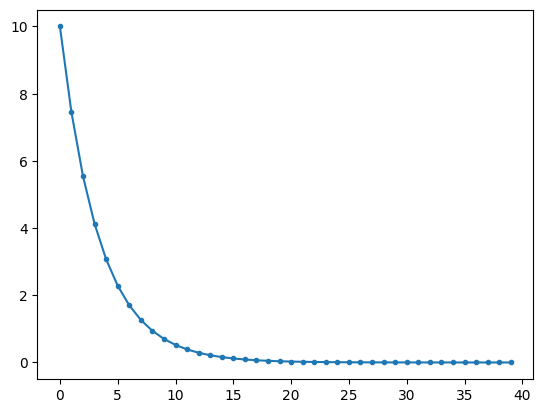

In [42]:
reg_params = np.geomspace(10, 0.0001, 40)

print(reg_params)

plt.plot(reg_params, marker=".")

In [14]:
from masterthesis.model import LinearBinarizedModel
from masterthesis.metrics import abs_delta, class_error

# Fitting
lin_model = LinearBinarizedModel(regularization=1000).fit(X_train, y_train)

print(lin_model.beta)
print(lin_model.theta)

# Predictions
y_pred_train = lin_model.predict(X_train)

print("(Train) Mean Absolute Delta:", abs_delta(y_train_trans, y_pred_train, mean=True))
print("(Train) Class Error:", class_error(y_train_trans, y_pred_train))

y_pred_test = lin_model.predict(X_test)

print("(Test) Predictions:", y_pred_test)

print("(Test) Mean Absolute Delta:", abs_delta(y_test_trans, y_pred_test, mean=True))
print("(Test) Class Error:", class_error(y_test_trans, y_pred_test))

lin_model

[ 2.93900142e-01  1.79770339e-01  5.63835038e-01  6.70140794e-01
 -2.26899530e-02 -8.00216724e-01  9.62427817e-01 -8.03677961e-01
 -7.10537999e-04 -7.47236994e-01 -5.43638653e-01  1.83489646e-01
 -1.94134175e-01 -7.13952822e-02 -8.26001839e-03  3.53619138e-02
  6.24720432e-01  9.32382957e-02  4.89473755e-01 -3.69608435e-01
  7.46705116e-01 -4.12876340e-01  8.85006579e-01  7.56907854e-01
 -5.16777262e-01  1.09066106e-01]
[-4.19418722 -3.47351606 -1.5363196  -1.3317969   0.09230499  0.75199896
  3.46038067]
(Train) Mean Absolute Delta: 1.7100271002710028
(Train) Class Error: 0.16802168021680217
(Test) Predictions: [6 4 6 4 2 7 2 6 4 4 6 2 0 6 6 4 6 6 6 6 7 4 6 4 4 6 4 2 6 6 2 6 0 2 6 4 0
 6 0 6 2 6]
(Test) Mean Absolute Delta: 1.9047619047619047
(Test) Class Error: 0.19047619047619047


LinearBinarizedModel(regularization=1000)